In [1]:
## import libraries
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch.optim as optim
import torch.nn.functional as F
from utils.dataloaders import context_inpainting_dataloader, segmentation_data_loader
from models import resnet18_encoderdecoder, resnet18_encoderdecoder_wbottleneck
from models import resnet18_coach_vae
from utils.prisma_preprocess import prisma_preproccessing , prisma_svd, min_max_normalization, dataset_creation, gt_preproccessing, basalt_patches, moon_preprocess
import rasterio
import os

import warnings
warnings.filterwarnings('ignore')

## fix seeds
torch.cuda.manual_seed(7)
torch.manual_seed(7)
np.random.seed(7)

In [2]:
for filename in os.listdir('datasets/ground_truth/'):
    path = os.path.join('datasets/ground_truth/', filename) # join the path
    numpy_array = rasterio.open(path).read()
    print("the initial gt has shape {}".format(numpy_array.shape))
    print("the gt has values{}".format(np.unique(numpy_array)))

for images in os.listdir('datasets/images/'):
    path = os.path.join('datasets/images/', images) # join the path
    if images.endswith('.tif') and images.startswith('PRS_'):
        numpy_array = rasterio.open(path).read()
        print("the initial gt has shape {}".format(numpy_array.shape))

the initial gt has shape (1, 1192, 1189)
the gt has values[0. 1.]
the initial gt has shape (231, 1196, 1204)
the initial gt has shape (231, 1197, 1202)
the initial gt has shape (231, 1196, 1204)
the initial gt has shape (231, 1196, 1205)
the initial gt has shape (231, 1194, 1214)


the initial image has shape (231, 1196, 1204)
cutting the absorbed bands...
the final image has shape (210, 930, 930)
the final image has max value 0.9800564646720886
the final image has min value 0.0


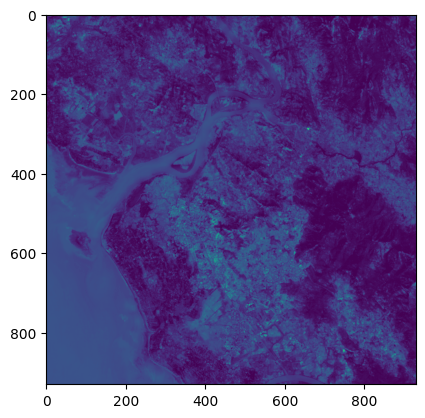

the initial image has shape (231, 1197, 1202)
cutting the absorbed bands...
the final image has shape (207, 930, 930)
the final image has max value 0.9583937525749207
the final image has min value 0.0


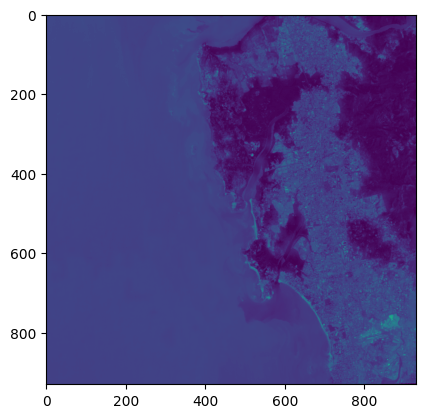

the initial image has shape (231, 1196, 1204)
cutting the absorbed bands...
the final image has shape (213, 930, 930)
the final image has max value 0.9781200885772705
the final image has min value 0.0


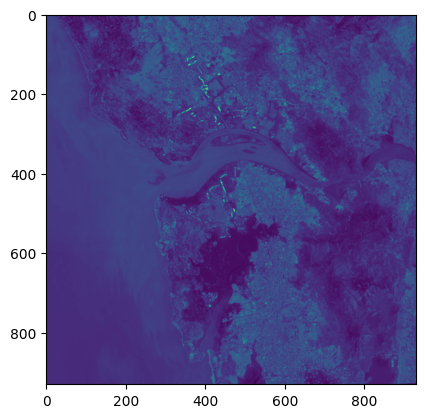

the initial image has shape (231, 1196, 1205)
cutting the absorbed bands...
the final image has shape (211, 930, 930)
the final image has max value 0.9993133544921875
the final image has min value 0.0


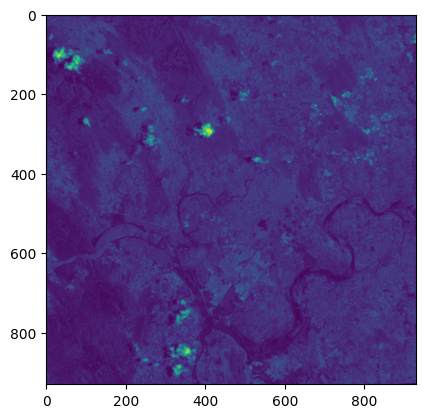

the initial image has shape (231, 1194, 1214)
cutting the absorbed bands...
the final image has shape (219, 930, 930)
the final image has max value 0.8874494433403015
the final image has min value 0.0


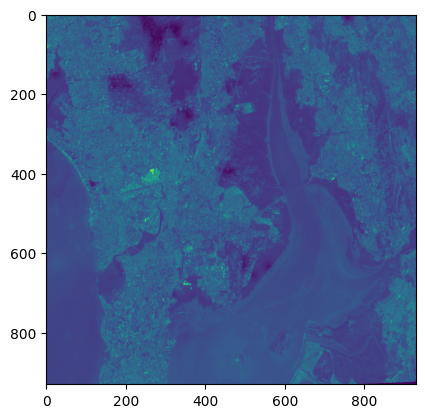

In [17]:
prisma_preprocessed_list = []
for filename in os.listdir('datasets/images/'):
    path = os.path.join('datasets/images/', filename) # join the path
    if filename.endswith('.tif') and filename.startswith('PRS_'):
        file_preprocessed = prisma_preproccessing(path) # preprocess the image
        plt.imshow(file_preprocessed[30,:,:])
        plt.show()
        #+prisma_reduced = prisma_svd(file_preprocessed, 3, plot=True) # apply svd to the image
        prisma_preprocessed_list.append(file_preprocessed)

In [18]:
basalt_image = prisma_preprocessed_list[3]

In [9]:
for filename in os.listdir('datasets/ground_truth/'):
    path = os.path.join('datasets/ground_truth/', filename) # join the path
    gt_array = gt_preproccessing(path)

the initial gt has shape (1, 1192, 1189)
the final gt has shape (1, 930, 930)
the final gt has  value [0. 1.]


In [20]:
print(basalt_image.shape)

(211, 930, 930)


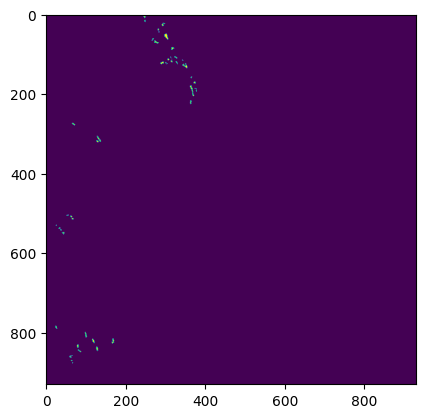

[0. 1.]
(930, 930)
(211, 930, 930)


In [29]:
plt.imshow(gt_array[0,:,:])
plt.show()
#basalt = np.where(gt_array[0,:,:] == 1)
print(np.unique(gt_array[0,:,:]))
print(gt_array[0,:,:].shape)
basalt_pixels = []
for i in range(0, basalt_image.shape[0]):
    array = (basalt_image[i, :, :]* (gt_array[0,:,:]))
    basalt_pixels.append(array)
basalt_pixels = np.array(basalt_pixels)
print(basalt_pixels.shape)



In [37]:
basalt_mean = []
for i in range(0, basalt_pixels.shape[0]):
    basalt = np.where(basalt_pixels[i,:,:] != 0, basalt_pixels[i,:,:], np.nan)
    basalt_mean.append(np.nanmean(basalt))

211


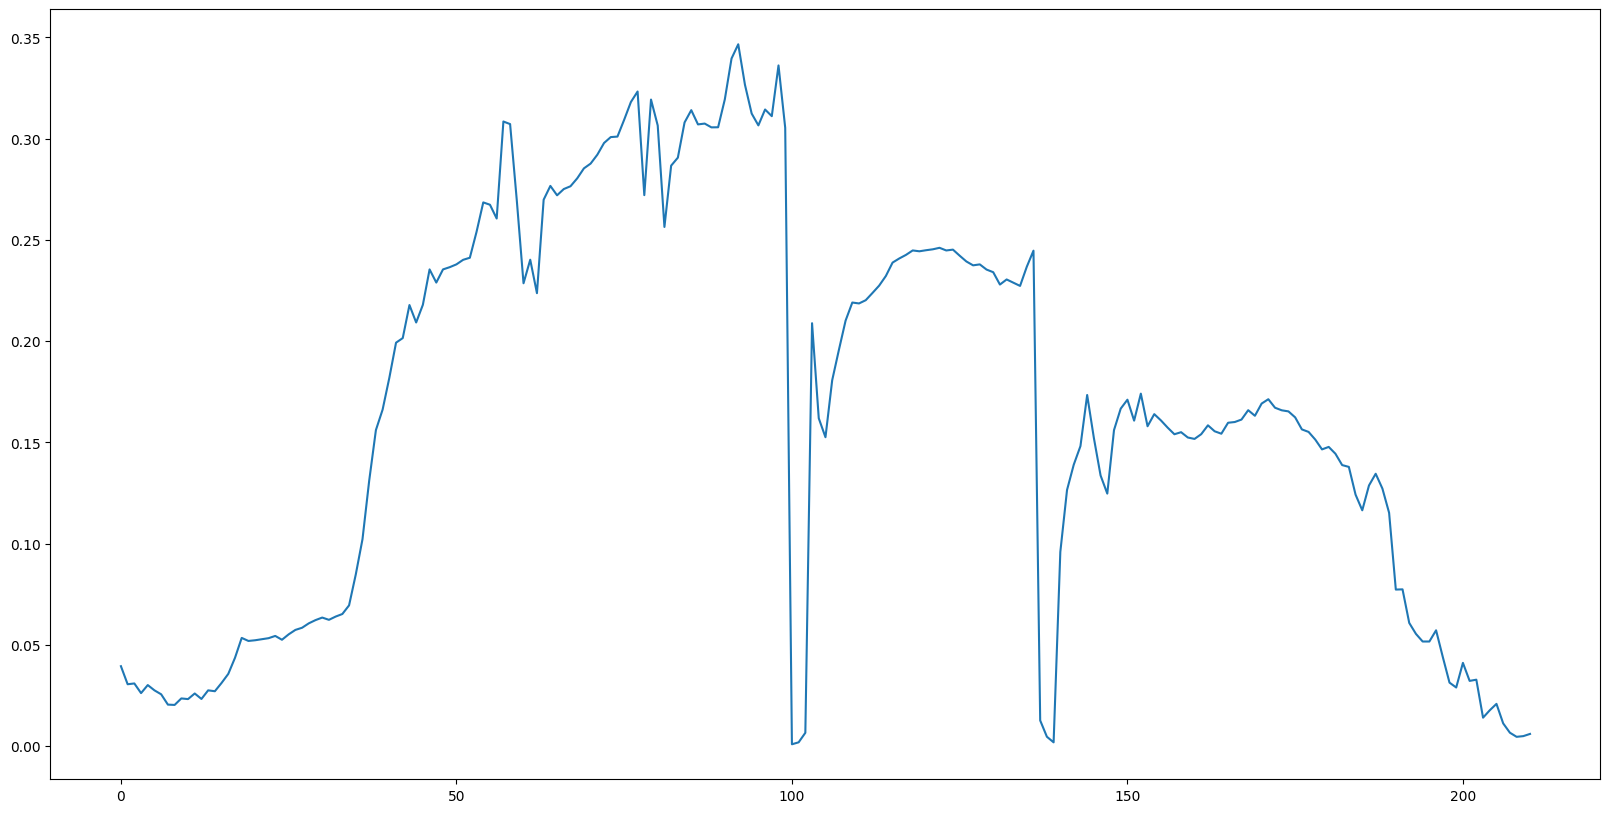

In [40]:
print(len(basalt_mean))
plt.figure(figsize=(20,10))
plt.plot(basalt_mean)

In [21]:
basalt_images, basalt_gt = basalt_patches(dataset, gt_dataset)
print("the basalt images has shape {}".format(basalt_images.shape))
print("the basalt gt has shape {}".format(basalt_gt.shape))





the basalt images has shape (150, 3, 448, 448)
the basalt gt has shape (150, 1, 448, 448)


In [22]:
basalt_images_train = basalt_images[:int(0.8*basalt_images.shape[0]),:,:,:]
basalt_images_val = basalt_images[int(0.8*basalt_images.shape[0]):,:,:,:]
basalt_gt_train = basalt_gt[:int(0.8*basalt_gt.shape[0]),:,:,:]
basalt_gt_val = basalt_gt[int(0.8*basalt_gt.shape[0]):,:,:,:]

In [23]:
print("the basalt images train has shape {}".format(basalt_images_train.shape))
print("the basalt gt train has shape {}".format(basalt_gt_train.shape))
print("the basalt images val has shape {}".format(basalt_images_val.shape))
print("the basalt gt val has shape {}".format(basalt_gt_val.shape))

the basalt images train has shape (120, 3, 448, 448)
the basalt gt train has shape (120, 1, 448, 448)
the basalt images val has shape (30, 3, 448, 448)
the basalt gt val has shape (30, 1, 448, 448)


In [24]:
np.save('datasets/training/basalt_images_train.npy', basalt_images_train)
np.save('datasets/training/basalt_gt_train.npy', basalt_gt_train)
np.save('datasets/validation/basalt_images_val.npy', basalt_images_val)
np.save('datasets/validation/basalt_gt_val.npy', basalt_gt_val)

<class 'numpy.ndarray'>


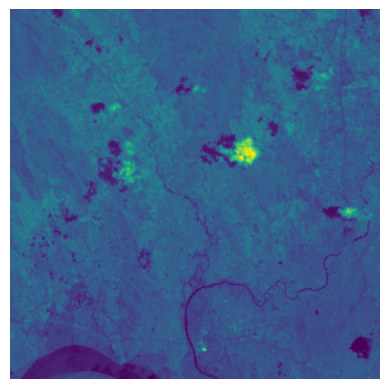

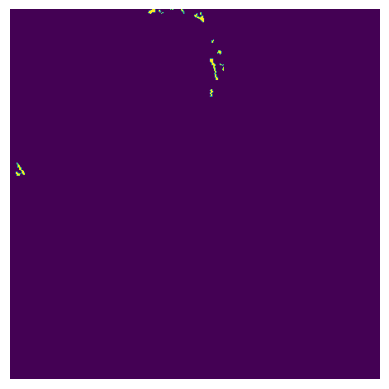

In [25]:
print(type(basalt_images))
plt.imshow(basalt_images[56,0,:,:])
plt.axis('off')
plt.show()
plt.imshow(basalt_gt[56,0,:,:])
plt.axis('off')
plt.show()

In [3]:
#the moon preprocessing
label_path = 'datasets/images/moon/basalts_moon_labelling_clip.tif'
path = 'datasets/images/moon/m3g20090210t012132_v01_rfl.tif'
#moon_array = rasterio.open(path).read()
#label_moon_array = rasterio.open(label_path).read()

In [4]:
moon_preprocessed = moon_preprocess(path)
print("the moon preprocessed has shape {}".format(moon_preprocessed.shape))

the initial image has shape (85, 14165, 304)
the initial image has max value 3.255291223526001
the initial image has min value -999.0
the moon preprocessed has shape (85, 14165, 304)


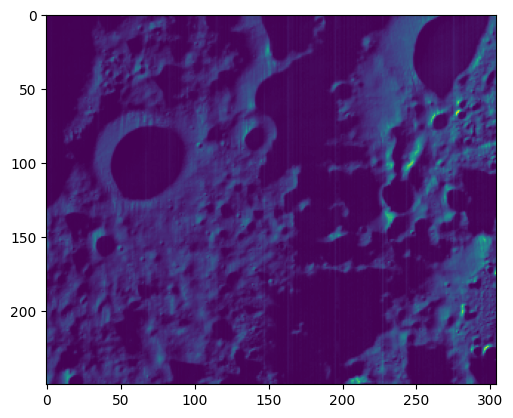

In [5]:
#plt.imshow(label_moon_array[0,:,:])
#plt.show()
plt.imshow(moon_preprocessed[38,250:500, :])
plt.show()
#print(np.max(moon_array), np.min(moon_array))
#print(np.unique(label_moon_array))

the rearranged image has shape (14165, 304, 85)
the reshaped image has shape (4306160, 85)
the normalized image has max value 1.0
the normalized image has min value 0.0
the transformed image has max value 1.0
the transformed image has min value 0.0
the transformed image has shape (4306160, 3)
the reshaped transformed image has shape (3, 14165, 304)


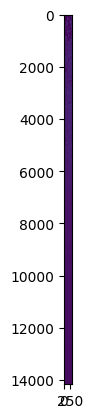

the explained variance is [0.9713296  0.00974662 0.00162798]


In [6]:
moon_svd = prisma_svd(moon_preprocessed, 3, plot=True)

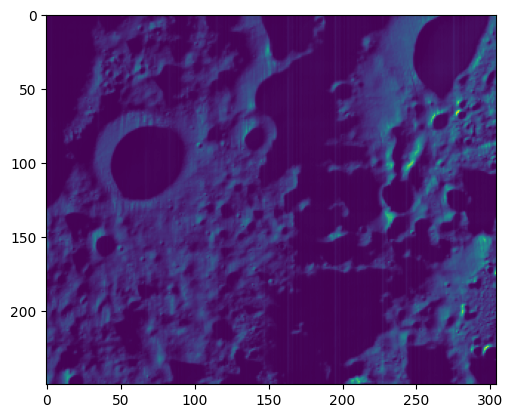

In [11]:
plt.imshow(moon_svd[0,250:500, :])
plt.show()

In [42]:
ones_array = np.zeros((3,moon_svd.shape[1], 448 - moon_svd.shape[2]))

moon_total_image = np.concatenate((moon_svd, ones_array), axis=2)
print("the moon total image has shape {}".format(moon_total_image.shape))
print(len(moon_total_image))
chunk_size = 448
subarrays = [moon_total_image[:,i:i + chunk_size,:] for i in range(0, moon_total_image.shape[1], chunk_size)]
print(len(subarrays))
print(subarrays[0].shape)
#moon_dataset = np.array(subarrays)

the moon total image has shape (3, 14165, 448)
3
32
(3, 448, 448)


(16, 3, 448, 448)


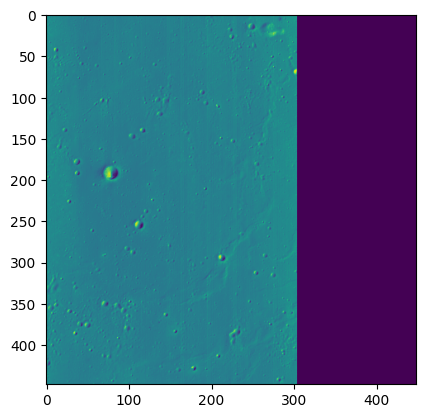

In [63]:
#subarrays =[]
chunk_size = 448
subarray = moon_total_image[:,chunk_size*17:chunk_size*18,:] # get the subarray
subarrays.append(subarray)
array_subarray = np.array(subarrays)
print(array_subarray.shape)
plt.imshow(subarray[0,:,:])
plt.show()

In [ ]:
np.save('datasets/moon_test/moon_dataset.npy', array_subarray)